<a href="https://colab.research.google.com/github/SilahicAmil/End-To-End-SkimLit/blob/main/End_To_End_SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2: Skim Lit

### Purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

 * The paper we're replicating ( [Arxiv](https://arxiv.org/abs/1710.06071))

* Reading through the paper above we see that the model architecture that they use to achieve their best reuslts is available here: [Arxiv](https://arxiv.org/abs/1612.05251)


## Confirm to access to GPU

In [1]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-869814e9-c126-de5f-bef1-8b147c189d25)


## Get the data

Since we'll be replication the paper above (PubMed 200k RCT). Lets download the dataset they used.

We can do so from the authors GitHub: [Franck Dernoncourt](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments with 20k Dataset with number replaced by "@"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all filenames in target
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

Now we have some text data, time to become one with the data

One of the best ways to become one with the data is to..

> Visualize, Visualize, Visualize

With that in mind lets, write a function to read in all of the lines of a target text file


In [6]:
# Create function to read lines

def get_lines(filename):

  """

  Reads filename of text and returns lines of text as a list.

  Args:
    filenamne: a string contaning the target filepath

  Returns:
    A list of strings with one string per line from target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read in the training lines

train_lines = get_lines(data_dir+"train.txt") # Read train text lines

train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)


210040

Thinking how we want the data to look

How I think our data would be best represented:

```
[{'line_number' : 0,
    'target' : BACKGROUND,
    'text' : "Emotional eating is associated with overeating and the development of obesity .\n "  # String
    'total_lines': 11},
    ...]
  ```  

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename. Reads contents. Sorts through each line, extracting target label, text of sentence, and how many sentences are in each abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from file
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list

# Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): #Check if an ID Line
      abstract_id = line
      abstract_lines = "" # Reset abstract string if the line is an ID line
    elif line.isspace(): # Check if new line
      abstract_line_split = abstract_lines.splitlines() # Split abstracts into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create empty dictionary
        target_text_split = abstract_line.split("\t") # Split target label from text
        line_data["target"] = target_text_split[0] # Get target label
        line_data["text"] = target_text_split[1].lower() # Get target text and lower
        line_data["line_number"] = abstract_line_number # Number of line in abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


In [10]:
# Get data from file and preprocess

%%time

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples) , len(val_samples) , len(test_samples))

180040 30212 30135
CPU times: user 528 ms, sys: 94.2 ms, total: 623 ms
Wall time: 631 ms


In [11]:
# Check first abstract of trining data

train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in format of list of dictionaries. Lets turn it into a DF to visualize it

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Check spread of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

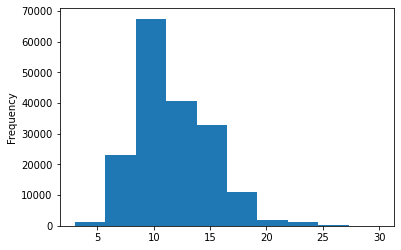

In [14]:
# Check len of different lines

train_df.total_lines.plot.hist();

### Get a list of sentences 

In [15]:
# Convert abstract text to lists

train_sentences = train_df["text"].tolist()

val_sentences = val_df["text"].tolist()

test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View first 10 lines of training

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels



In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label Econcoded Labels

In [18]:
# Extract labels

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class and map it to text

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0 - Baseline Model

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Words -> Numbers
                    ("clf", MultinomialNB()) # Models Text
])

# Fit model
model_0.fit(train_sentences, train_labels_encoded)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
baseline_scores = model_0.score(val_sentences, val_labels_encoded)
print(f"Baseline Models Achieves an Accuracy of: {baseline_scores*100:.2f}%")

Baseline Models Achieves an Accuracy of: 72.18%


In [22]:
# Making Predictions
baseline_predict = model_0.predict(val_sentences)
baseline_predict[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-16 00:01:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-16 00:01:28 (97.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_predict)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing text for sequence models

Before we start building deep sequence models. We have to create vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [27]:
# How long is each sentence (avg)
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

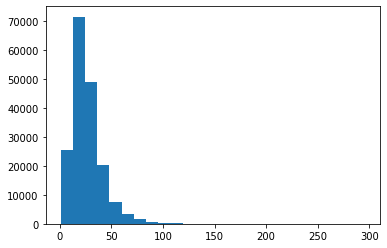

In [28]:
# Whats the distribution?

import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=25);

In [29]:
# How long of a sentence covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Max sequence length
max(sent_lens)

296

## Text Vectorization Layer

In [31]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens= 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Words In Vocab
                                    output_sequence_length=output_seq_len,# Desired output length of vectorized text
                                    pad_to_max_tokens=True) 

In [32]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [33]:
#Test out text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 adverse events were comparable between both groups with a tendency of more complaints in the nha group .

Length of text: 18

Vectorized text: [[  118   124     9   550    30    54    24     7     8  3741     4    69
   3636     5     2 25555    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of text vectorizer

text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

## Custom text embedding

In [36]:
# Create token embedding layers

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Length of vocab
                              output_dim=128, # Different embedding sizes result in drastically different number of params (Similar to n_estimators SciKitLearn)
                              mask_zero=True, # Use masking to handle the variable sequence length (save space/time)
                              name="token_embedding")
 

In [37]:
# Exmaple embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n ")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 adverse events were comparable between both groups with a tendency of more complaints in the nha group .
Sentence after vectorization:
[[  118   124     9   550    30    54    24     7     8  3741     4    69
   3636     5     2 25555    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
 
Sentence after embedding:
 [[[-0.02475789 -0.01745769 -0.02966195 ...  0.01269609 -0.04135871
    0.02263186]
  [ 0.02482588  0.02144617  0.04431802 ... -0.00711665 -0.04469701
    0.02375604]
  [ 0.01532884  0.04262244 -0.0127241  ... -0.03728343  0.04900551
   -0.00269919]
  ...
  [ 0.028864    0.01763325  0.02115728 ... -0.04719846 -0.02379569
    0.0211602 ]
  [ 0.028864    0.01763325  0.02115728 ... -0.04719846 -0.02379569
    0.0211602 ]
  [ 0.028864    0.01763325  0.02115728 ..

## Creating Datasets

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API.

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [39]:
# Take TensorSlice datasets and turn into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1 : Conv1D Wth token embed

In [40]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense output

outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile MOdel

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [42]:
# Fit the model

hist_model_1 = model_1.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=3,
                           validation_data=valid_dataset,
                           validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 78s 83ms/step - loss: 0.9266 - accuracy: 0.6311 - val_loss: 0.6929 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 46s 82ms/step - loss: 0.6581 - accuracy: 0.7573 - val_loss: 0.6313 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 45s 81ms/step - loss: 0.6169 - accuracy: 0.7747 - val_loss: 0.5963 - val_accuracy: 0.7839


In [43]:
# Evaluate on validation set full
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5966 - accuracy: 0.7865


[0.5966047644615173, 0.7864755988121033]

In [44]:
# Make predictions (makes predictions for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.4847336e-01, 1.5763159e-01, 6.3815102e-02, 3.0678257e-01,
         2.3297358e-02],
        [4.4673958e-01, 2.8649381e-01, 1.5468190e-02, 2.4136372e-01,
         9.9347150e-03],
        [1.3556643e-01, 5.2620294e-03, 1.6862276e-03, 8.5745460e-01,
         3.0667161e-05],
        ...,
        [6.9483176e-06, 7.7847234e-04, 6.0449634e-04, 4.0871755e-06,
         9.9860603e-01],
        [4.3885402e-02, 4.6266964e-01, 9.1242187e-02, 4.7308501e-02,
         3.5489422e-01],
        [1.8173002e-01, 6.8302613e-01, 4.2080168e-02, 4.4100046e-02,
         4.9063675e-02]], dtype=float32), (30212, 5))

In [45]:
# Covnert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate results

model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred= model_1_preds)
model_1_results

{'accuracy': 78.64755726201508,
 'f1': 0.783700763997366,
 'precision': 0.7830620205995316,
 'recall': 0.7864755726201509}

In [47]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now to use pretrained word embeddings from TensorFlow Hub.

In [48]:
# Download pretrained embedded USE encoder
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
# Test our pretrained embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:25]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 fpca was applied for data analysis .
Sentence after embedding:
 [ 0.06728859  0.02249623  0.02955665  0.00756917  0.03029126 -0.08587875
 -0.0084553  -0.03112215  0.07005867 -0.03568137 -0.02617388 -0.01453765
  0.08391716 -0.00712116 -0.05049446 -0.03345156  0.0216989  -0.00578584
  0.06929688 -0.02306698 -0.05963921  0.01065591 -0.07085935 -0.02831063
 -0.03906336]
Length of sentence embedding: 512


## Building and fitting and NLP feature extraction model using USE


In [50]:
# Define feature extraction model

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # Tokenize and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# YOU COULD ADD MORE LAYERS HERE
outputs= layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extract")

#Compile model

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extract"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit the model to data

hist_model_2 = model_2.fit(train_dataset,
                           epochs=3,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           validation_data=valid_dataset,
                           validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9092 - accuracy: 0.6549 - val_loss: 0.7951 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7670 - accuracy: 0.7040 - val_loss: 0.7518 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7494 - accuracy: 0.7127 - val_loss: 0.7347 - val_accuracy: 0.7134


In [53]:
# Evaluate on entire valid dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7379 - accuracy: 0.7145


[0.7378867864608765, 0.7144843339920044]

In [54]:
# Make Predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.5164794e-01, 3.3873624e-01, 3.2438503e-03, 1.9800913e-01,
        8.3628409e-03],
       [3.1463742e-01, 5.4780728e-01, 4.6991804e-03, 1.2986574e-01,
        2.9903941e-03],
       [2.2696853e-01, 1.2945387e-01, 1.7820321e-02, 5.9230298e-01,
        3.3454318e-02],
       ...,
       [1.5507103e-03, 6.5199919e-03, 4.1916512e-02, 9.4505341e-04,
        9.4906777e-01],
       [3.9726361e-03, 5.0856881e-02, 2.0459719e-01, 1.5894035e-03,
        7.3898387e-01],
       [1.7232803e-01, 2.8854361e-01, 4.8239130e-01, 5.6842482e-03,
        5.1052839e-02]], dtype=float32)

In [55]:
# Convert pred probs to labels

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.44843108698531,
 'f1': 0.7113522233922343,
 'precision': 0.7145607949577631,
 'recall': 0.7144843108698531}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [58]:
model_1_results

{'accuracy': 78.64755726201508,
 'f1': 0.783700763997366,
 'precision': 0.7830620205995316,
 'recall': 0.7864755726201509}

## Model 3: Conv1D with Character Embeddings

### Create a character level tokenzier

In [59]:
# Make function to split sentences into charactes

def split_chars(text):
  return " ".join(list(text))

# Text splitting non character level to characters
split_chars(random_train_sentence)

'f p c a   w a s   a p p l i e d   f o r   d a t a   a n a l y s i s   .'

In [60]:
# Split sequence level data to character level data

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:6]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

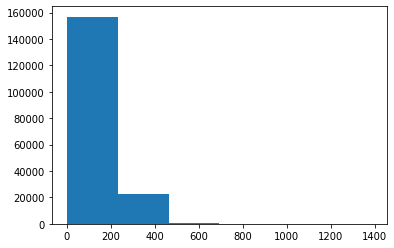

In [62]:
# Check distribution
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=6);

In [63]:
# Find 95% percentile
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [64]:
# Get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [65]:
# Create char level token vectorizer

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [66]:
# Adapt char vectorizer to training characters

char_vectorizer.adapt(train_chars)

In [67]:
# Check character vocab stat
char_vocab = char_vectorizer.get_vocabulary()
print(f" Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters {char_vocab[-5:]}")

 Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters ['k', 'x', 'z', 'q', 'j']


In [68]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Char Text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized Chars:\n {vectorized_chars}")
print(f"\n Length of vectorized chars {len(vectorized_chars[0])}")

Char Text:
 t o   c o m p a r e   t h e   c l i n i c a l   o u t c o m e s   o f   w a v e f r o n t - g u i d e d   a n d   w a v e f r o n t - o p t i m i z e d   l a s e r   i n   s i t u   k e r a t o m i l e u s i s   (   l a s i k   )   .
Length of random_train_chars: 101

Vectorized Chars:
 [[ 3  7 11  7 15 14  5  8  2  3 13  2 11 12  4  6  4 11  5 12  7 16  3 11
   7 15  2  9  7 17 20  5 21  2 17  8  7  6  3 18 16  4 10  2 10  5  6 10
  20  5 21  2 17  8  7  6  3  7 14  3  4 15  4 25  2 10 12  5  9  2  8  4
   6  9  4  3 16 23  2  8  5  3  7 15  4 12  2 16  9  4  9 12  5  9  4 23
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

## Creating a character level embedding

In [69]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # Size of char embedding in the paper (Figure 1)
                              mask_zero=True,
                              name="char_embed")



In [70]:
# Test char embedding
print(f"Char text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded char: \n {char_embed_example}")
print(f" Char embedded shape: {char_embed_example.shape}")

Char text:
 t o   c o m p a r e   t h e   c l i n i c a l   o u t c o m e s   o f   w a v e f r o n t - g u i d e d   a n d   w a v e f r o n t - o p t i m i z e d   l a s e r   i n   s i t u   k e r a t o m i l e u s i s   (   l a s i k   )   .

Embedded char: 
 [[[-0.00813832 -0.0381654   0.0095086  ... -0.0086871   0.00415719
    0.03690939]
  [ 0.00434952  0.01975283 -0.0004145  ... -0.03612005 -0.02784207
   -0.02586356]
  [ 0.01243589 -0.02935945 -0.04506022 ...  0.0074648   0.0097445
   -0.03489759]
  ...
  [ 0.00512787 -0.04687832 -0.03095392 ... -0.02597036 -0.03470268
   -0.03987205]
  [ 0.00512787 -0.04687832 -0.03095392 ... -0.02597036 -0.03470268
   -0.03987205]
  [ 0.00512787 -0.04687832 -0.03095392 ... -0.02597036 -0.03470268
   -0.03987205]]]
 Char embedded shape: (1, 290, 25)


### Building a Conv1D Model for character level embedding

In [71]:
# Conv1D on chars

inputs = layers.Input(shape=(1,), dtype="string")

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(char_embeddings)
x= layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embed")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [72]:
model_3.summary()

Model: "model_3_conv1d_char_embed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_______________________________________

In [73]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [74]:
# Fit model

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.2855 - accuracy: 0.4885 - val_loss: 1.0813 - val_accuracy: 0.5848
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0187 - accuracy: 0.5949 - val_loss: 0.9444 - val_accuracy: 0.6340
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9373 - accuracy: 0.6329 - val_loss: 0.8744 - val_accuracy: 0.6606


In [75]:
# Make preds for character level

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.16471218, 0.4271497 , 0.12292471, 0.24083795, 0.04437543],
       [0.12181204, 0.47951978, 0.02180958, 0.29734   , 0.0795186 ],
       [0.07401226, 0.303779  , 0.08962699, 0.4902175 , 0.04236425],
       ...,
       [0.01577584, 0.03055256, 0.11059434, 0.02029161, 0.82278574],
       [0.02633646, 0.1331755 , 0.3065201 , 0.02967778, 0.50429016],
       [0.42731854, 0.32051235, 0.1490217 , 0.0754335 , 0.02771401]],
      dtype=float32)

In [76]:
# Convert pred probs to class labels

model_3_preds= tf.argmax(model_3_pred_probs, axis=1)
model_3_preds 

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [77]:
# Calculate reuslts for Conv1D Model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.94439295644115,
 'f1': 0.6396510818405972,
 'precision': 0.6422434583538944,
 'recall': 0.6494439295644114}

In [78]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 4: Comibing pretrained token embeddins and character embeddings

In [83]:
# 1 Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")

token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2 Create a character level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM in Figure 1 of paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3 Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4 Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#5 Construct model

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], # Order in which it will receive the dataset. Token first, char second
                         outputs=output_layer,
                         name="model_4_hybrid")

In [84]:
# Get a summary
model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
_____________________________________________________________________________________

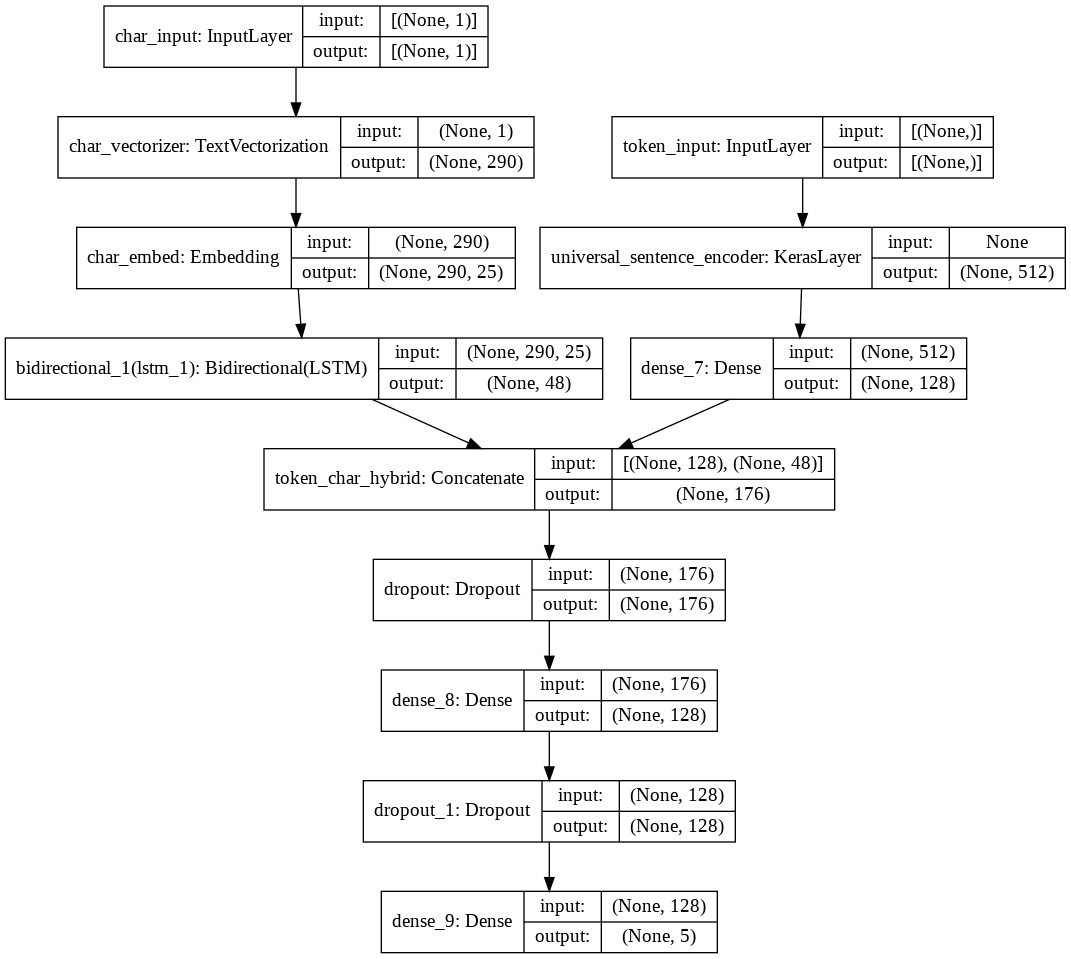

In [91]:
# Plot hybrid model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [102]:
# Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a Dataset

Functionize below at a later date 

In [97]:
# Combine chars and tokens to dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combine Data


# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [98]:
# Validation Data

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # Combine Data

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [99]:
# Test Data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # Combine Data

# Prefetch and batch test data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [100]:
# Check train char and token dataset

train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting the model

In [103]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 56ms/step - loss: 0.9788 - accuracy: 0.6105 - val_loss: 0.7792 - val_accuracy: 0.6985
Epoch 2/3
562/562 [==============================] - 28s 51ms/step - loss: 0.7979 - accuracy: 0.6912 - val_loss: 0.7118 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7758 - accuracy: 0.7038 - val_loss: 0.6989 - val_accuracy: 0.7367


In [114]:
# Evaluate model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.7038 - accuracy: 0.7322


[0.7037891745567322, 0.7322255969047546]

In [115]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.2704639e-01, 3.5832229e-01, 4.2280699e-03, 2.0287456e-01,
        7.5287968e-03],
       [3.1714290e-01, 5.4241067e-01, 3.5781951e-03, 1.3450220e-01,
        2.3660848e-03],
       [3.2530662e-01, 1.5924799e-01, 5.0182078e-02, 4.2479414e-01,
        4.0469058e-02],
       ...,
       [5.1979232e-04, 8.0081187e-03, 5.4717783e-02, 2.2183907e-04,
        9.3653244e-01],
       [6.0862689e-03, 5.8295965e-02, 2.1901467e-01, 2.8127448e-03,
        7.1379030e-01],
       [2.6786608e-01, 4.7649530e-01, 1.7987029e-01, 2.9346196e-02,
        4.6422102e-02]], dtype=float32)

In [116]:
# Format pred probs into pred labels

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [118]:
# Get results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.22256057195816,
 'f1': 0.7295379505943496,
 'precision': 0.7350814672670841,
 'recall': 0.7322256057195816}

In [148]:
# Summary of all the scores for all 4 models
print(f"Baseline Scores: {baseline_results}")
print(f"\nModel 1- Conv1D - Token Embedded: {model_1_results}")
print(f"\nModel 2- Feature Extraction w/ Pretrained token embeddings (USE): {model_2_results}")
print(f"\nModel 3- Conv1D - Character Embedded: {model_3_results}")
print(f"\nModel 4 - Hybrid Model - Token and Character Embedded: {model_4_results}")

Baseline Scores: {'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1': 0.6989250353450294}

Model 1- Conv1D - Token Embedded: {'accuracy': 78.64755726201508, 'precision': 0.7830620205995316, 'recall': 0.7864755726201509, 'f1': 0.783700763997366}

Model 2- Feature Extraction w/ Pretrained token embeddings (USE): {'accuracy': 71.44843108698531, 'precision': 0.7145607949577631, 'recall': 0.7144843108698531, 'f1': 0.7113522233922343}

Model 3- Conv1D - Character Embedded: {'accuracy': 64.94439295644115, 'precision': 0.6422434583538944, 'recall': 0.6494439295644114, 'f1': 0.6396510818405972}

Model 4 - Hybrid Model - Token and Character Embedded: {'accuracy': 73.22256057195816, 'precision': 0.7350814672670841, 'recall': 0.7322256057195816, 'f1': 0.7295379505943496}
